In [42]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")
at.set_included_mice([409828])
at.set_included_columns([1])
at.set_included_volumes([3])

In [3]:
em_client = EMClient()
ophys_client = OPhysClient("chase")

In [292]:
coreg = em_client.get_coregistration_table(drop_duplicates=False)
print(len(coreg))
coreg.head()

167


,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,NaN,...,3,M409828_13,0,117,M409828_13_0_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,NaN,...,3,M409828_13,0,75,M409828_13_0_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,NaN,...,3,M409828_13,0,26,M409828_13_0_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,NaN,...,3,M409828_13,0,163,M409828_13_0_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,NaN,...,3,M409828_13,0,31,M409828_13_0_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


Ensure that the coregistered cells are valid, non-duplicates

In [293]:
roi_df = pd.read_csv("/Users/chase/Desktop/v1dd_M409828_13_roi_depths.csv")
roi_df["roi_lookup"] = roi_df.apply(lambda row: f"M409828_13_{row['plane']}_{row['roi']}", axis=1)
roi_df

,plane,roi,n_other_duplicates,has_dup_below,has_dup_above,depth,weighted_depth,depth_min,depth_max,roi_lookup
0,0,0,1,False,True,242,245.361559,234,266,M409828_13_0_0
1,0,1,1,False,True,242,246.476536,234,266,M409828_13_0_1
2,0,2,0,False,False,242,242.000000,234,250,M409828_13_0_2
3,0,3,1,False,True,242,247.898773,234,266,M409828_13_0_3
4,0,4,0,False,False,242,242.000000,234,250,M409828_13_0_4
...,...,...,...,...,...,...,...,...,...,...
1896,5,706,0,False,False,322,322.000000,314,330,M409828_13_5_706
1897,5,722,0,False,False,322,322.000000,314,330,M409828_13_5_722
1898,5,723,0,False,False,322,322.000000,314,330,M409828_13_5_723
1899,5,776,0,False,False,322,322.000000,314,330,M409828_13_5_776


In [294]:
# Add ROI centroid to roi_df
centroid_map = {}
for group in iter_plane_groups():
    centroid_map[group.attrs["plane"]] = group["roi_centroids"][()]

def _get_centroid(row, weighted=True):
    centroid = centroid_map[row["plane"]][row["roi"]]
    depth = row["weighted_depth"] if weighted else row["depth"]
    return np.array([centroid[1], depth, centroid[0]])

roi_df["roi_centroid"] = roi_df.apply(lambda row: _get_centroid(row, weighted=True), axis=1)
roi_df["roi_centroid_unweighted"] = roi_df.apply(lambda row: _get_centroid(row, weighted=False), axis=1)
roi_df.head()

,plane,roi,n_other_duplicates,has_dup_below,has_dup_above,depth,weighted_depth,depth_min,depth_max,roi_lookup,roi_centroid,roi_centroid_unweighted
0,0,0,1,False,True,242,245.361559,234,266,M409828_13_0_0,"[359.47196261682245, 245.3615594265786, 46.364...","[359.47196261682245, 242.0, 46.36448598130841]"
1,0,1,1,False,True,242,246.476536,234,266,M409828_13_0_1,"[188.09146341463415, 246.4765360584388, 165.5]","[188.09146341463415, 242.0, 165.5]"
2,0,2,0,False,False,242,242.000000,234,250,M409828_13_0_2,"[315.9186046511628, 242.0, 343.20348837209303]","[315.9186046511628, 242.0, 343.20348837209303]"
3,0,3,1,False,True,242,247.898773,234,266,M409828_13_0_3,"[266.6825396825397, 247.89877279915493, 206.93...","[266.6825396825397, 242.0, 206.93121693121694]"
4,0,4,0,False,False,242,242.000000,234,250,M409828_13_0_4,"[356.69473684210527, 242.0, 32.34736842105263]","[356.69473684210527, 242.0, 32.34736842105263]"


In [295]:
coreg = coreg[coreg.roi.isin(roi_df.roi_lookup)]
coreg.reset_index(inplace=True, drop=True)
print(len(coreg))
coreg.head()

149


,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,NaN,...,3,M409828_13,0,117,M409828_13_0_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,NaN,...,3,M409828_13,0,75,M409828_13_0_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,NaN,...,3,M409828_13,0,26,M409828_13_0_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,NaN,...,3,M409828_13,0,163,M409828_13_0_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,NaN,...,3,M409828_13,0,31,M409828_13_0_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


In [296]:
# Load the corresponding 2P ROI centroids (this is a slow approach lol)
coreg["ophys_pos"] = coreg.roi.apply(pd.Series(index=roi_df.roi_lookup.values, data=roi_df.roi_centroid.values).get)
coreg["ophys_pos_unweighted"] = coreg.roi.apply(pd.Series(index=roi_df.roi_lookup.values, data=roi_df.roi_centroid_unweighted.values).get)
coreg.head()

,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,...,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete,ophys_pos,ophys_pos_unweighted
0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,NaN,...,0,117,M409828_13_0_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True,"[172.085020242915, 242.0, 194.4412955465587]","[172.085020242915, 242.0, 194.4412955465587]"
1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,NaN,...,0,75,M409828_13_0_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True,"[223.954128440367, 242.0, 177.954128440367]","[223.954128440367, 242.0, 177.954128440367]"
2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,NaN,...,0,26,M409828_13_0_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False,"[317.9895104895105, 244.535250545588, 25.79020...","[317.9895104895105, 242.0, 25.79020979020979]"
3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,NaN,...,0,163,M409828_13_0_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False,"[391.4754098360656, 242.0, 71.68306010928961]","[391.4754098360656, 242.0, 71.68306010928961]"
4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,NaN,...,0,31,M409828_13_0_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False,"[446.2681818181818, 242.0, 90.2090909090909]","[446.2681818181818, 242.0, 90.2090909090909]"


In [297]:
print("Plane | Coreg ROI Count")
coreg.ophys_plane.value_counts().sort_index()

Plane | Coreg ROI Count


0    24
1    14
2    46
3    20
4    30
5    15
Name: ophys_plane, dtype: int64

# Plot the 2P and EM positions

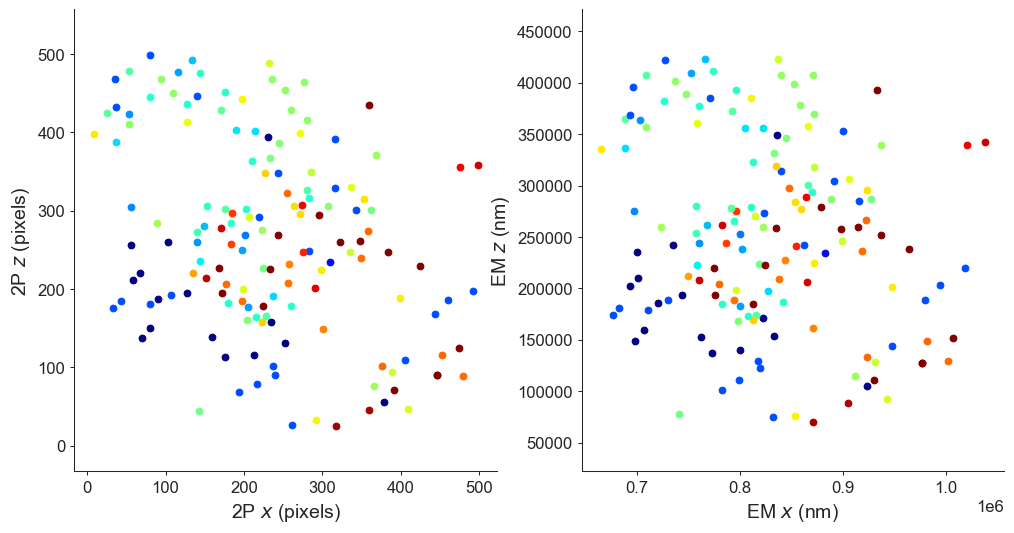

In [298]:
coreg_pts_em = np.vstack(coreg.pt_position.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $z$ (pixels)")
axs[1].set_xlabel("EM $x$ (nm)")
axs[1].set_ylabel("EM $z$ (nm)")

cmap = plt.get_cmap("jet_r")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    color = cmap(cmap_norm(coreg_pts_ophys[i, 1])) # scatter.get_facecolors()[0]

    axs[0].scatter(coreg_pts_ophys[i, 0], coreg_pts_ophys[i, 2], color=color)
    axs[1].scatter(coreg_pts_em[i, 0], coreg_pts_em[i, 2], color=color)

for ax in axs:
    ax.axis("equal")

# fig.colorbar(axs[1])

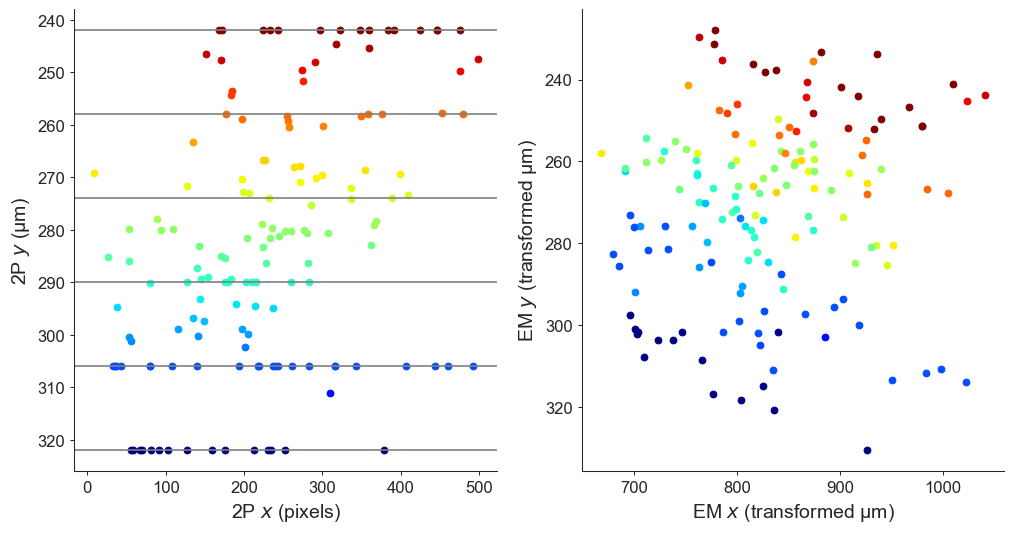

In [304]:
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)
# coreg_pts_ophys = np.vstack(coreg.ophys_pos_unweighted.values)

# coreg_pts_em = np.vstack(coreg.pt_position.values)
coreg_pts_em = np.vstack(coreg.position_microns.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $y$ (µm)")
# axs[1].set_xlabel("EM $x$ (nm)")
# axs[1].set_ylabel("EM $y$ (nm)")
axs[1].set_xlabel("EM $x$ (transformed µm)")
axs[1].set_ylabel("EM $y$ (transformed µm)")

cmap = plt.get_cmap("jet_r")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    color = cmap(cmap_norm(coreg_pts_ophys[i, 1])) # scatter.get_facecolors()[0]

    axs[0].scatter(coreg_pts_ophys[i, 0], coreg_pts_ophys[i, 1], color=color)
    axs[1].scatter(coreg_pts_em[i, 0], coreg_pts_em[i, 1], color=color)

for ax in axs:
    # ax.axis("equal")
    ax.invert_yaxis()

for y in range(242, 330, 16):
    axs[0].axhline(y=y, color="gray")

# fig.colorbar(axs[1])

(746503.8, 1052264.2, 53775.0, 409185.0)

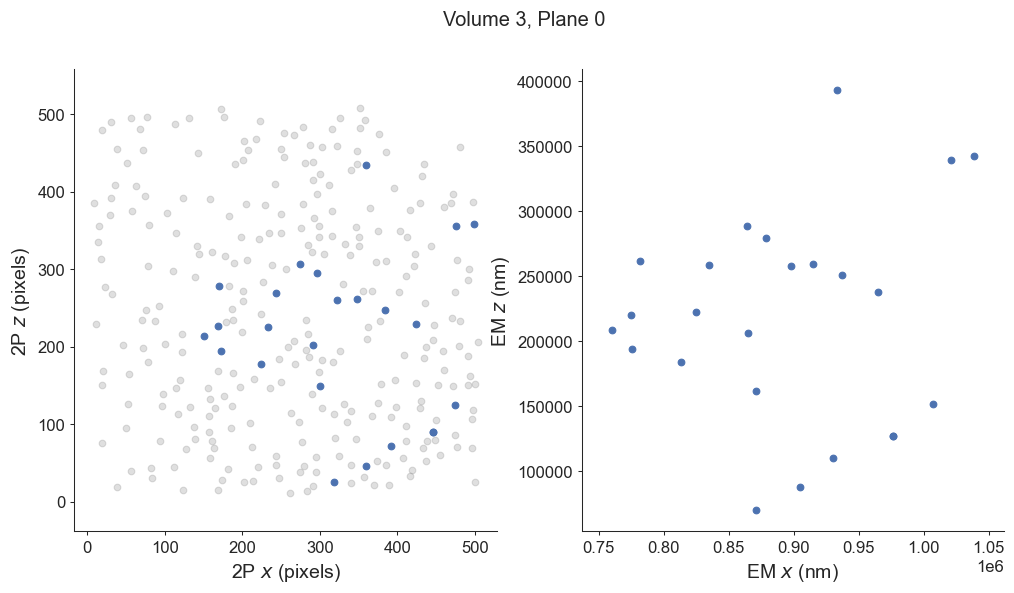

In [305]:
coreg_pts_em = np.vstack(coreg.pt_position.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $z$ (pixels)")
axs[1].set_xlabel("EM $x$ (nm)")
axs[1].set_ylabel("EM $z$ (nm)")

plane = 0
mask = coreg.ophys_plane == plane
# mask = coreg.ophys_plane.isin([plane, plane+1])
other_ophys_rois = np.vstack(roi_df[(roi_df.plane == plane) & ~roi_df.roi.isin(coreg.ophys_roi[coreg.ophys_plane == plane].values)].roi_centroid)
axs[0].scatter(coreg_pts_ophys[mask, 0], coreg_pts_ophys[mask, 2], color="b")
axs[0].scatter(other_ophys_rois[:, 0], other_ophys_rois[:, 2], color="gray", alpha=0.25)
axs[1].scatter(coreg_pts_em[mask, 0], coreg_pts_em[mask, 2], color="b")

fig.suptitle(f"Volume 3, Plane {plane}")
axs[0].axis("equal")
axs[1].axis("equal")

# fig.colorbar(axs[1])

# Fit affine transformation for ROIs in a small set of planes

In [323]:
# plane = 1
# fit_mask = coreg.ophys_plane == plane
# fit_mask = coreg.ophys_plane.isin([plane-1, plane, plane+1]) # Fit to 3 planes
fit_mask = coreg.index # Fit to all planes

rois_2p = coreg.apply(lambda row: f"{row.ophys_plane}-{row.ophys_roi}", axis=1).values
pos_2p = np.vstack(coreg.ophys_pos.values[fit_mask])
pos_em = np.vstack(coreg.pt_position.values[fit_mask])

P = np.column_stack((pos_2p, np.ones(len(pos_2p))))
C = pos_em

np.random.seed(123)
n = len(P)
n_train = int(n * 0.75)
# n_train = n-5
print(f"n = {n}, n_train = {n_train}")
rand_idx = np.random.permutation(n)

P_train, P_test = P[:n_train], P[n_train:]
C_train, C_test = C[:n_train], C[n_train:]

X = np.linalg.solve(np.matmul(P_train.T, P_train), np.matmul(P_train.T, C_train))
X

n = 149, n_train = 111


array([[ 7.52823556e+02,  4.96367495e+01,  5.43470233e+01],
       [ 2.28104498e+01,  9.76652898e+02,  1.99363118e+01],
       [ 6.99427644e+01, -2.61783698e+02,  7.68393646e+02],
       [ 6.27027247e+05,  3.97346754e+05,  3.05676489e+04]])

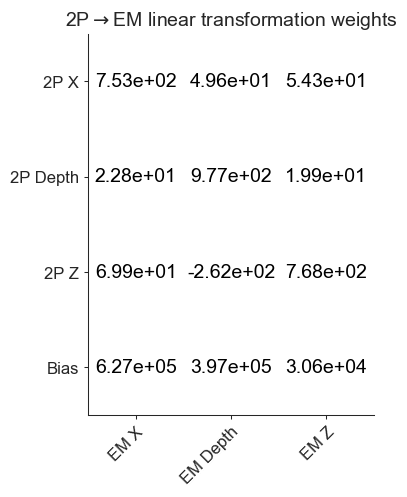

In [324]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(X, cmap="hot_r", vmin=0, vmax=0) # make everything white

row_labels = ["2P X", "2P Depth", "2P Z", "Bias"]
col_labels = ["EM X", "EM Depth", "EM Z"]

ax.set_xticks(np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(len(row_labels)), labels=row_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        text = ax.text(j, i, f"{X[i, j]:.2e}", fontsize=14, ha="center", va="center", color="black")

ax.set_title("2P$\\rightarrow$EM linear transformation weights")
fig.tight_layout()

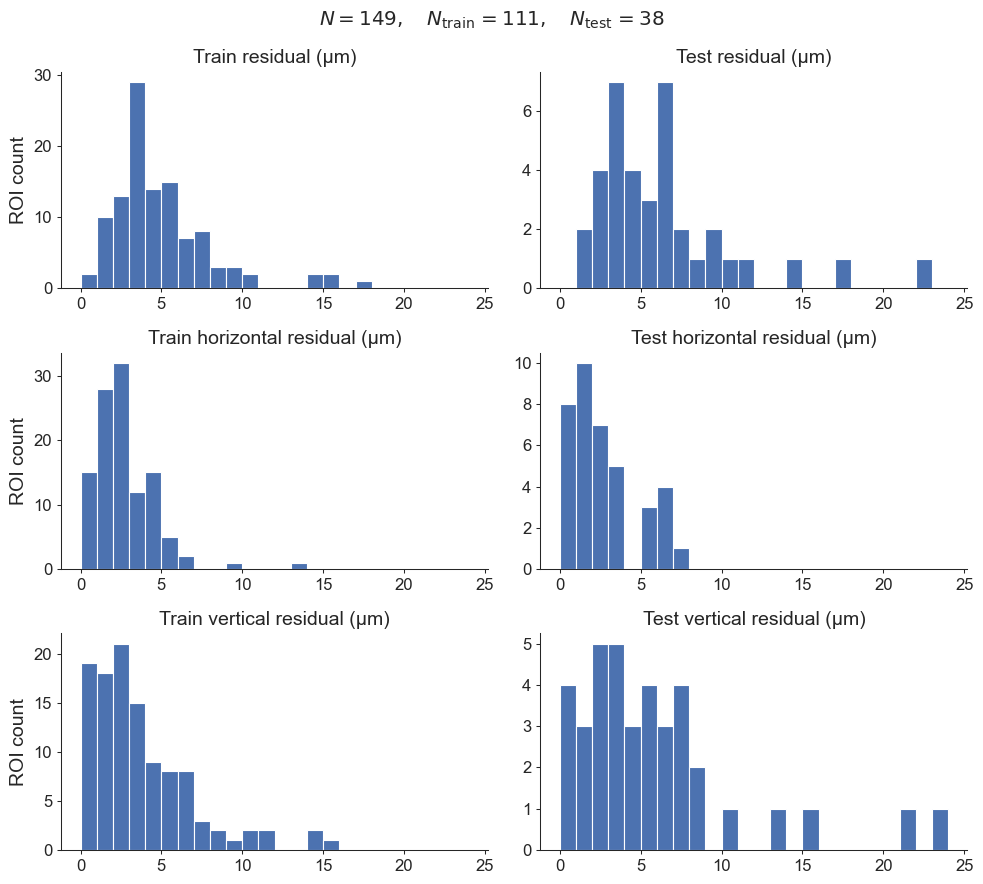

In [326]:
# Compute distance errors in microns
delta_microns = []
delta_microns_horiz = []
delta_microns_vert = []
for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns.append(np.linalg.norm(ci_true - ci_pred) / 1000)
    delta_microns_horiz.append(np.linalg.norm(ci_true[::2] - ci_pred[::2]) / 1000)
    delta_microns_vert.append(abs(ci_true[1] - ci_pred[1]) / 1000)

fig, axs = plt.subplots(figsize=(10, 9), nrows=3, ncols=2)
bins = np.arange(0, int(np.max(delta_microns))+1)

axs[0, 0].hist(delta_microns[:n_train], bins=bins)
axs[0, 0].set_title("Train residual (µm)")
axs[0, 0].set_ylabel("ROI count")
axs[0, 1].hist(delta_microns[n_train:], bins=bins)
axs[0, 1].set_title("Test residual (µm)")

ax = axs[1, 0]
ax.hist(delta_microns_horiz[:n_train], bins=bins)
ax.set_title("Train horizontal residual (µm)")
ax.set_ylabel("ROI count")
ax = axs[1, 1]
ax.hist(delta_microns_horiz[n_train:], bins=bins)
ax.set_title("Test horizontal residual (µm)")

ax = axs[2, 0]
ax.hist(delta_microns_vert[:n_train], bins=bins)
ax.set_title("Train vertical residual (µm)")
ax.set_ylabel("ROI count")
ax = axs[2, 1]
ax.hist(delta_microns_vert[n_train:], bins=bins)
ax.set_title("Test vertical residual (µm)")

fig.suptitle(f"$N = {n}, \quad N_\\operatorname{{train}} = {n_train}, \quad N_\\operatorname{{test}} = {n-n_train}$")
fig.tight_layout()

(645957.9, 1057052.1, 53969.15773774794, 441724.65471047803)

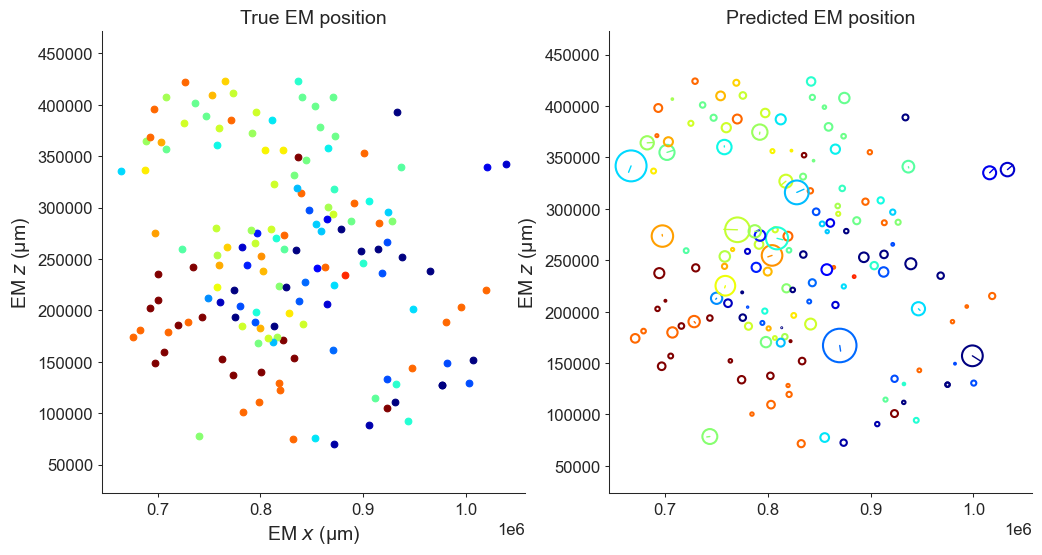

In [327]:
# Width (not area) of point is proportional to the prediction error in microns
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
# axs[0].set_xlabel("True EM $x$ (µm)")
# axs[0].set_ylabel("True EM $z$ (µm)")
# axs[1].set_xlabel("Predicted EM $x$ (µm)")
# axs[1].set_ylabel("Predicted EM $z$ (µm)")
axs[0].set_xlabel("EM $x$ (µm)")
axs[0].set_ylabel("EM $z$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")
axs[0].set_title("True EM position")
axs[1].set_title("Predicted EM position")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=pos_2p[:, 1].min(), vmax=pos_2p[:, 1].max())

for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred) / 1000
    color = cmap(cmap_norm(pi[1]))

    axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)
    axs[1].scatter(ci_pred[0], ci_pred[2], color="none", edgecolor=color, linewidth=1.5, s=delta_microns**2)
    if delta_microns > 8:
        axs[1].plot([ci_true[0], ci_pred[0]], [ci_true[2], ci_pred[2]], color=color, linestyle="solid", linewidth=1)

axs[0].axis("equal")
axs[1].axis("equal")


(645957.9, 1057052.1, 52221.52975759594, 441807.8750904853)

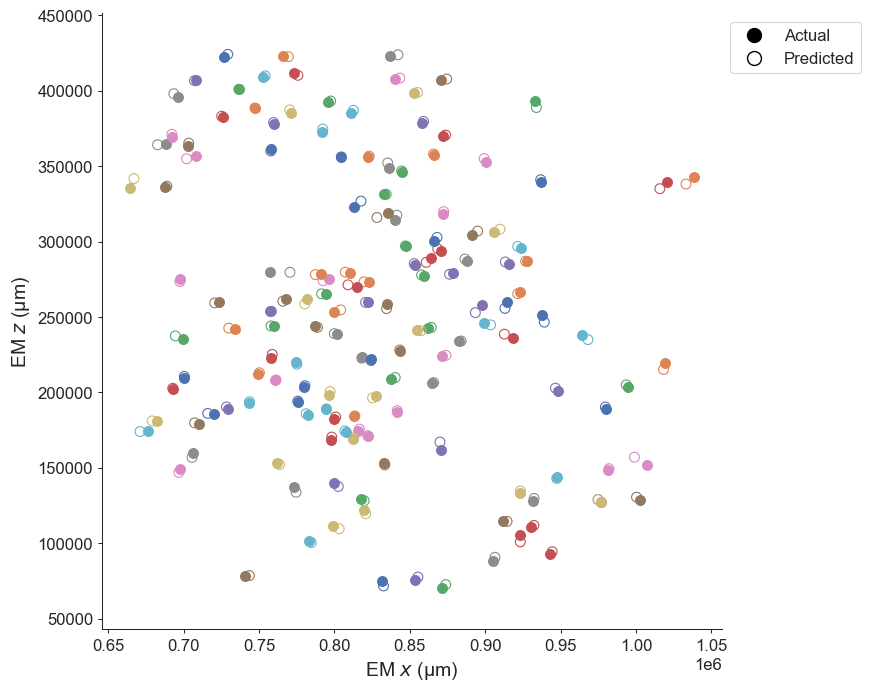

In [362]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel("EM $x$ (µm)")
ax.set_ylabel("EM $z$ (µm)")

# cmap = plt.get_cmap("jet")
# cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    color = cmap(cmap_norm(pi[1]))

    color = ax.scatter(ci_true[0], ci_true[2], s=50).get_facecolors()[0]
    ax.scatter(ci_pred[0], ci_pred[2], facecolors="none", edgecolors=color, s=50)

ax.legend(handles=[
    mpl.lines.Line2D([0], [0], label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
    mpl.lines.Line2D([0], [0], label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
], loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
ax.axis("equal")

# For the cells in train/test, measure the distance to other nearby cells (as margin of error)

In [330]:
def find_somas_near_predicted_point(pt, horiz_tol_microns, vert_tol_microns):
    r = max(horiz_tol_microns, vert_tol_microns) * 1000
    somas = em_client.get_cells_in_box(min_voxels=pt-r, max_voxels=pt+r, drop_duplicates=True)
    somas["residual_vert_microns"] = somas.pt_position.apply(lambda pos: abs(pos[1] - pt[1]) / 1000)
    somas = somas[somas.residual_vert_microns <= vert_tol_microns]
    somas["residual_horiz_microns"] = somas.pt_position.apply(lambda pos: np.linalg.norm(pos[::2] - pt[::2]) / 1000)
    somas = somas[somas.residual_horiz_microns <= horiz_tol_microns]
    somas["residual_microns"] = somas.pt_position.apply(lambda pos: np.linalg.norm(pos - pt) / 1000)
    somas.reset_index(inplace=True, drop=True)
    return somas

In [364]:
n_soma_nearby_of_pred = []
score = []
is_correct = []

df = []

for i in tqdm(range(n)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    pred_err_dist = np.linalg.norm(ci_true - ci_pred) / 1000
    pred_err_horiz_dist = np.linalg.norm(ci_true[::2] - ci_pred[::2]) / 1000
    pred_err_vert_dist = abs(ci_true[1] - ci_pred[1]) / 1000

    # Find somas 
    somas_near_pred_pt = find_somas_near_predicted_point(ci_pred, horiz_tol_microns=16, vert_tol_microns=10)
    n_soma_nearby_of_pred.append(len(somas_near_pred_pt))

    if len(somas_near_pred_pt) > 0:
        dist_to_somas = np.sort(somas_near_pred_pt.residual_microns.values)
        closest_dist = dist_to_somas[0]
        second_closest_dist = np.nan

        if len(somas_near_pred_pt) >= 2:
            # closest_dist, second_closest_dist = np.partition(dist_to_somas, 2)[:2]
            second_closest_dist = dist_to_somas[1]
            s = 1 - closest_dist / (second_closest_dist*2)
        else:
            s = 1
        
        score.append(s)
        # correct_pred = pred_err_dist == closest_dist
        correct_pred = pred_err_horiz_dist == somas_near_pred_pt.residual_horiz_microns.min()
        is_correct.append(correct_pred)

        df.append(dict(
            correct = correct_pred,
            score = s,
            err = pred_err_dist,
            err_horiz = pred_err_horiz_dist,
            err_vert = pred_err_vert_dist,
            top_3_closest = dist_to_somas[:3], # " | ".join([f'{d:.2f}' for d in dist_to_somas[:3]]),
            top_3_closest_horiz = somas_near_pred_pt.residual_horiz_microns.sort_values().values[:3], #" | ".join([f'{d:.2f}' for d in somas_near_pred_pt.residual_horiz_microns.sort_values().values[:3]]),
            top_3_closest_vert = somas_near_pred_pt.residual_vert_microns.sort_values().values[:3], #" | ".join([f'{d:.2f}' for d in somas_near_pred_pt.residual_vert_microns.sort_values().values[:3]]),
        ))

        # print(f"{'Correct' if correct_pred else 'Incorrect'}! Closest cell is {closest_dist:.2f} µm from predicted point (err = {pred_err_dist:.2f}; horiz err = {pred_err_horiz_dist:.2f}, vert err = {pred_err_vert_dist:.2f}; n_nearby = {len(somas_near_pred_pt)}; top 3 closest = {})")
    else:
        print(f"No nearby somas found!!! (error = {pred_err_dist:.2f}; horiz error = {pred_err_horiz_dist:.2f}, vert error = {pred_err_vert_dist:.2f})")

df = pd.DataFrame(df)

df.head(50)

  0%|          | 0/149 [00:00<?, ?it/s]

,correct,score,err,err_horiz,err_vert,top_3_closest,top_3_closest_horiz,top_3_closest_vert
0,True,0.699949,4.696501,0.382061,4.680934,"[4.696500612795341, 7.826182502722066, 15.8847...","[0.3820613958439831, 2.228933530133571, 15.838...","[1.217065574504086, 4.680934425495914, 7.50206..."
1,True,0.969110,0.603218,0.580321,0.164620,"[0.6032177518527522, 9.763895349912037, 12.835...","[0.5803205444756033, 9.582833152907817, 9.9888...","[0.16461993138690015, 1.8716199313869002, 2.41..."
2,True,0.765512,4.591215,3.784544,2.599324,"[4.591215022981357, 9.789857206214782, 14.2850...","[3.784543751440864, 9.587678634214287, 13.9691...","[0.5046762455054559, 1.9793237544945441, 2.599..."
3,True,0.910103,2.504023,2.207952,1.181135,"[2.504023293562271, 13.927144253281773]","[2.20795220497229, 10.7066849033293]","[1.18113492678036, 8.90686507321964]"
4,True,0.816695,3.143384,2.569419,1.810787,"[3.143384244331731, 8.574182005369352, 10.1763...","[2.569418959980005, 7.562839569787494, 7.74772...","[0.05221268073574174, 1.1897873192642583, 1.81..."
5,True,0.808075,3.690996,2.599037,2.620775,"[3.6909961344691298, 9.615726677551828, 15.091...","[2.5990366978988138, 9.599334656398288, 13.403...","[0.5612251703663497, 2.1912251703663497, 2.620..."
6,True,0.915163,1.309982,1.125024,0.671098,"[1.3099817472682471, 7.720576760552902, 13.051...","[1.1250243107778017, 7.67625349165673, 11.8081...","[0.6710979647822678, 0.8260979647822678, 1.137..."
7,True,0.921743,1.815964,1.704530,0.626341,"[1.8159641192821048, 11.602556759623981, 12.21...","[1.7045298760324568, 11.552121035148499, 12.13...","[0.6263414278433193, 1.0806585721566808, 1.402..."
8,True,0.823716,4.574431,1.282586,4.390944,"[4.574430806198361, 12.974632396700883, 13.824...","[1.282585664849117, 12.949445227452275, 13.364...","[0.8080557720439974, 3.5369442279560026, 4.390..."
9,True,0.878578,2.858986,0.203535,2.851732,"[2.85898574844325, 11.772901095287036]","[0.2035353469533126, 9.376066486420878]","[2.851731556851417, 7.119731556851417]"


In [360]:
print(f"Train accuracy: {df.correct.values[:n_train].sum()}/{n_train} ({df.correct.values[:n_train].mean()*100:.1f}%)")
print(f"Test accuracy:  {df.correct.values[n_train:].sum()}/{n-n_train} ({df.correct.values[n_train:].mean()*100:.1f}%)")

print()
score_thresh = 0.75
print(f"High scores (≥ {score_thresh})")
df_high_score = df[df.score >= score_thresh]
correct_train = df_high_score.loc[:n_train].correct
correct_test = df_high_score.loc[n_train:].correct
print(f"Train accuracy: {correct_train.sum()}/{len(correct_train)} ({correct_train.mean()*100:.1f}%)")
print(f"Test accuracy:  {correct_test.sum()}/{len(correct_test)} ({correct_test.mean()*100:.1f}%)")

Train accuracy: 89/111 (80.2%)
Test accuracy:  25/38 (65.8%)

High scores (≥ 0.75)
Train accuracy: 63/70 (90.0%)
Test accuracy:  13/17 (76.5%)


Text(0.5, 1.0, 'Score')

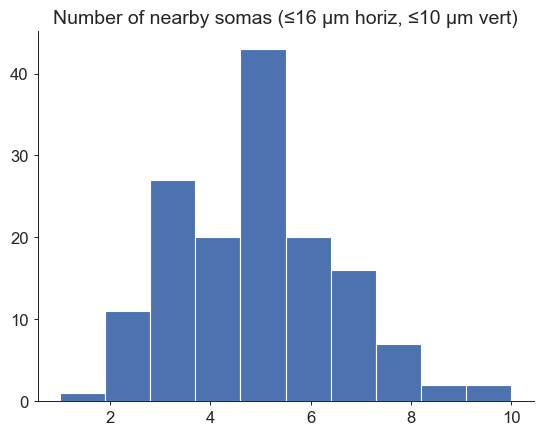

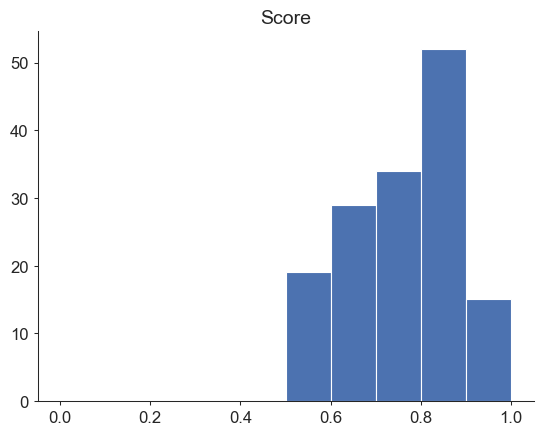

In [365]:
plt.hist(n_soma_nearby_of_pred)
plt.title("Number of nearby somas (≤16 µm horiz, ≤10 µm vert)")

plt.figure()
plt.hist(score, bins=np.arange(0, 1.1, 0.1))
plt.title("Score")

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 4., 3., 6., 2., 5., 3.,
        2., 0., 1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

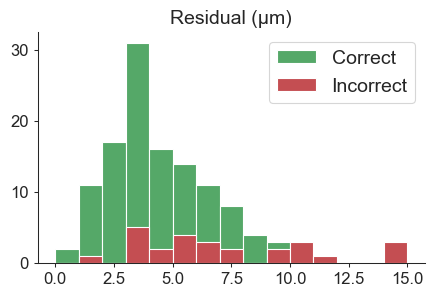

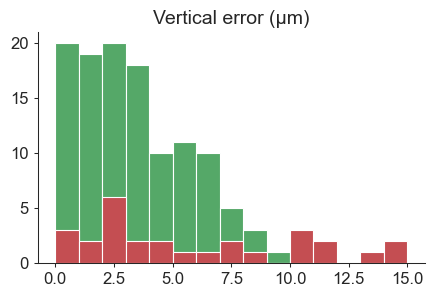

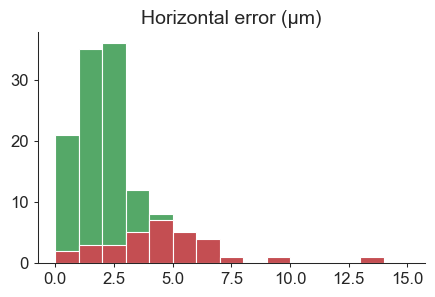

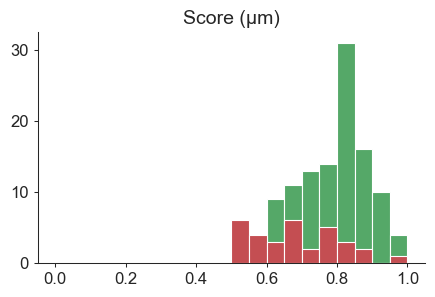

In [366]:
bins = np.arange(0, 16)

plt.figure(figsize=(5, 3))
plt.title("Residual (µm)")
plt.hist(df.err[df.correct], color="g", bins=bins, label="Correct")
plt.hist(df.err[~df.correct], color="r", bins=bins, label="Incorrect")
plt.legend(fontsize=14)

plt.figure(figsize=(5, 3))
plt.title("Vertical error (µm)")
plt.hist(df.err_vert[df.correct], color="g", bins=bins)
plt.hist(df.err_vert[~df.correct], color="r", bins=bins)

plt.figure(figsize=(5, 3))
plt.title("Horizontal error (µm)")
plt.hist(df.err_horiz[df.correct], color="g", bins=bins)
plt.hist(df.err_horiz[~df.correct], color="r", bins=bins)

plt.figure(figsize=(5, 3))
plt.title("Score (µm)")
bins = np.arange(0, 1.05, 0.05)
plt.hist(df.score[df.correct], color="g", bins=bins)
plt.hist(df.score[~df.correct], color="r", bins=bins)

In [367]:
df.iloc[n_train:]

,correct,score,err,err_horiz,err_vert,top_3_closest,top_3_closest_horiz,top_3_closest_vert
111,True,0.861555,4.394269,0.222739,4.388620,"[4.39426868969717, 15.870083069453957, 15.9983...","[0.2227389477356009, 14.372631656518696, 14.59...","[4.388619905894622, 6.2423800941053775, 7.0266..."
112,True,0.661722,3.947026,0.323320,3.933762,"[3.9470261872588304, 5.834001683605752, 14.455...","[0.32332044757417094, 5.711920903708712, 14.34...","[1.1872384908223756, 1.7607615091776243, 2.662..."
113,True,0.862439,3.639956,0.886625,3.530322,"[3.6399556353677447, 13.23030805829227, 16.113...","[0.8866251796494309, 13.213869453369773, 14.64...","[0.6593219142532908, 3.5303219142532907, 6.712..."
114,True,0.950152,1.167221,1.166153,0.049921,"[1.1672213242086522, 11.707749381865876, 15.79...","[1.1661533178896166, 11.55417652489836, 15.018...","[0.04992052546236664, 1.8900794745376333, 2.66..."
115,False,0.685331,3.562863,1.305821,3.314940,"[5.861538424756529, 9.313827604171047, 9.73523...","[3.9941226166131045, 4.016959363396614, 5.8039...","[4.290060282601742, 7.815939717398258, 8.40306..."
116,False,0.863147,10.885806,6.410843,8.797833,"[2.772243164034019, 10.128530078175862, 10.885...","[0.9889885414791483, 3.4683833373005903, 6.410...","[1.1148327794196085, 2.5898327794196083, 8.797..."
117,False,0.976290,9.564115,5.558300,7.783161,"[0.4535374567605471, 9.564115118912756, 12.091...","[0.4421115658949173, 5.55830007945803, 7.83345...","[0.10116119802952744, 1.4201611980295274, 4.24..."
118,False,0.667446,22.276440,6.702817,21.244105,"[7.960975565077205, 11.969432413971333, 13.954...","[1.2892041150344873, 11.849793816256152, 13.94...","[0.40689490112580823, 1.6881050988741917, 7.85..."
119,False,0.582157,11.053784,2.024976,10.866721,"[5.613018676380457, 6.716661214446417, 8.92752...","[3.4523866969064496, 3.4875109719047943, 6.994...","[0.07527918227785267, 0.7787208177221473, 3.17..."
120,True,0.828429,2.859917,0.189955,2.853602,"[2.859917056212598, 8.334514201342301, 12.9854...","[0.18995530820137327, 4.5765183496869195, 10.9...","[0.13760168021079153, 2.8536016802107915, 4.56..."
